In [18]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import peakutils as pkuts
from scipy import fftpack
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq
from matplotlib.offsetbox import AnchoredOffsetbox
import datetime as datetime
from datetime import datetime, timedelta
import os
import ctypes
import imufusion
import sys

In [19]:
file = '10202023_pig2.txt'
header = 0

dat = pd.read_csv(file, header = header, dtype = str, delimiter = '|', names = ['Time','MISC','Packet','Message','RSSI'])
dat = dat[~dat.RSSI.str.contains('error')]
dat = dat[dat.MISC.str.contains('f|e|6')] # To keep voltage, temperature and motility data only
dat = dat.reset_index(drop=True)
dat_col = dat.Message
dat_col = dat_col.str.strip()
hexdat = dat_col.str.split(' ')

In [20]:
# Check data #
dat

,Time,MISC,Packet,Message,RSSI
0,13:08:28.499,0e,28331,fa 34 21 34 01 e8 ff 98 00 29 02 8c,-62
1,13:08:28.499,0f,30937,00 fe 09 ff 8a 23 94 00 70 00 c5 01 22,-48
2,13:08:28.499,0e,28332,fa 0d 21 45 01 ef ff 96 ff a6 02 4c,-62
3,13:08:28.499,0f,30938,00 fe 29 ff 25 23 37 00 57 00 91 01 39,-48
4,13:08:28.499,0e,28333,fa 3f 21 6c 02 05 ff bb ff 38 01 ee,-63
...,...,...,...,...,...
1514183,17:28:45.108,0e,0863,f8 99 fd 8d 1f 59 00 0a 00 ae 00 08,-75
1514184,17:28:45.108,0f,6473,00 14 b5 f8 45 18 51 00 17 00 0b 00 06,-45
1514185,17:28:45.108,0e,0864,f8 8e fd 8e 1f 58 00 0b 00 b3 00 06,-75
1514186,17:28:45.108,0f,6474,00 14 ba f8 50 18 52 00 15 00 09 00 0b,-45


In [21]:
# Select part of the data (from 13:08 to 17:28)
dat_short = dat[683333:1514188]

In [22]:
# Separate reference and local data based on the length of the Message (or MISC)
dat_bg = dat_short[dat_short.MISC == ' 0f '] # background
dat_lo = dat_short[dat_short.MISC == ' 0e '] # local

In [55]:
dat_short

,Time,MISC,Packet,Message,RSSI
683333,15:06:36.809,0f,7024,00 f9 83 f4 c8 1d ef 00 1a 00 0d 00 03,-47
683334,15:06:36.809,0f,7025,00 f9 84 f4 c2 1d f6 00 1c 00 12 00 02,-48
683335,15:06:36.810,0f,7026,00 f9 95 f4 c4 1d e5 00 1a 00 13 00 05,-48
683336,15:06:36.810,0f,7027,00 f9 9b f4 ca 1d df 00 17 00 0e 00 07,-48
683337,15:06:36.810,0f,7028,00 f9 aa f4 d8 1d dd 00 14 00 0e 00 06,-47
...,...,...,...,...,...
1514183,17:28:45.108,0e,0863,f8 99 fd 8d 1f 59 00 0a 00 ae 00 08,-75
1514184,17:28:45.108,0f,6473,00 14 b5 f8 45 18 51 00 17 00 0b 00 06,-45
1514185,17:28:45.108,0e,0864,f8 8e fd 8e 1f 58 00 0b 00 b3 00 06,-75
1514186,17:28:45.108,0f,6474,00 14 ba f8 50 18 52 00 15 00 09 00 0b,-45


In [24]:
dat_bg = dat_bg.reset_index(drop=True)
dat_bg_col = dat_bg.Message
dat_bg_col = dat_bg_col.str.strip()
hexdat_bg = dat_bg_col.str.split(' ')

for i in range(0, len(hexdat_bg)):
    hexdat_bg[i] = hexdat_bg[i][1:13] # To remove '00' in the front

In [25]:
dat_lo = dat_lo.reset_index(drop=True)
dat_lo_col = dat_lo.Message
dat_lo_col = dat_lo_col.str.strip()
hexdat_lo = dat_lo_col.str.split(' ')

In [26]:
dat_bg = dat_bg.assign(Temperature = np.nan, Voltage = np.nan)
dat_lo = dat_lo.assign(Temperature = np.nan, Voltage = np.nan)

In [27]:
# Refer to the website: https://github.com/adafruit/Adafruit_LSM6DS/blob/master/Adafruit_LSM6DS.cpp
# Depends on the configuration of IMU on CCS

XL_scale_range_2g = 0.061
XL_scale_range_4g = 0.122
G_scale_range_1000dps = 35
G_scale_range_2000dps = 70

# Convert hex to float of acceleration and angular velocity for local data
for k, ele in enumerate(hexdat_lo): # k: count; ele: item; local data
        if len(ele) == 12: # Only select those that have the correct length
            vlist=[]
            for i in range(0, 6):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i <= 2:
                    vlist.append(round(float(convert_value)*XL_scale_range_4g/1000, 2))
                else:
                    vlist.append(round(float(convert_value)*G_scale_range_1000dps/1000, 2))
                    
            dat_lo.Message[k] = vlist
            
        elif len(ele) == 4:
            dat_lo.Message[k] = 'NaN'
            for i in range(0, 2):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i == 0:
                 #   vlist.append(float((convert_value/1000)))
                    dat_lo.Voltage[k] = float((convert_value/1000))
                else:
                  #  vlist.append(float(convert_value))
                    dat_lo.Temperature[k] = float(convert_value)
        
        else:
            #print('Line Error!'+str(k))
            #print(ele)
            vlist = [] #add empty list on error

<ipython-input-27-29ab3a10163d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_lo.Message[k] = vlist


In [29]:
 # Get only the filename from the file path
_, filename = os.path.split(file)
date = filename.split('_')[0]
date = datetime.strptime(date, '%m%d%Y') #which takes in "MMDDYYYY" like only US people write date order
 # Convert "realtime" to datetime, adding the date
dat_lo["Time"] = dat_lo["Time"].str.strip()
dat_lo["Time"] = pd.to_datetime(dat_lo["Time"], format='%H:%M:%S.%f')
dat_lo["Time"] = dat_lo["Time"].apply(lambda t: datetime.combine(date, t.time()))
# Check for date rollover and increment the date when necessary
dat_lo["Time"] = dat_lo["Time"].mask(dat_lo["Time"].diff().dt.total_seconds() < 0, 
                                           dat_lo["Time"] + timedelta(days=1))

In [31]:
# Convert hex to float of acceleration and angular velocity for reference data
for k, ele in enumerate(hexdat_bg): # k: count; ele: item
        if len(ele) == 12: # Only select those that have the correct length
            vlist=[]
            for i in range(0, 6):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i <= 2:
                    vlist.append(round(float(convert_value)*XL_scale_range_4g/1000, 2))
                else:
                    vlist.append(round(float(convert_value)*G_scale_range_1000dps/1000, 2))
                    
            dat_bg.Message[k] = vlist
            
        elif len(ele) == 4:
            dat_bg.Message[k] = 'NaN'
            for i in range(0, 2):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i == 0:
                 #   vlist.append(float((convert_value/1000)))
                    dat_bg.Voltage[k] = float((convert_value/1000))
                else:
                  #  vlist.append(float(convert_value))
                    dat_bg.Temperature[k] = float(convert_value)
        
        else:
            #print('Line Error!'+str(k))
            #print(ele)
            vlist = [] #add empty list on error

<ipython-input-31-27f0577e3b95>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_bg.Message[k] = vlist


In [32]:
 # Get only the filename from the file path
_, filename = os.path.split(file)
date = filename.split('_')[0]
date = datetime.strptime(date, '%m%d%Y') #which takes in "MMDDYYYY" like only US people write date order
 # Convert "realtime" to datetime, adding the date
dat_bg["Time"] = dat_bg["Time"].str.strip()
dat_bg["Time"] = pd.to_datetime(dat_bg["Time"], format='%H:%M:%S.%f')
dat_bg["Time"] = dat_bg["Time"].apply(lambda t: datetime.combine(date, t.time()))
# Check for date rollover and increment the date when necessary
dat_bg["Time"] = dat_bg["Time"].mask(dat_bg["Time"].diff().dt.total_seconds() < 0, 
                                           dat_bg["Time"] + timedelta(days=1))

In [34]:
dat_lo[['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = np.nan
dat_bg[['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = np.nan

In [35]:
dat_lo.loc[dat_lo.Message != 'NaN', ['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = dat_lo[dat_lo.Message != 'NaN'].Message.tolist()
dat_bg.loc[dat_bg.Message != 'NaN', ['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = dat_bg[dat_bg.Message != 'NaN'].Message.tolist()

In [37]:
dat_lo["Packet"] = dat_lo["Packet"].astype(int) # Change data type to integer
dat_bg["Packet"] = dat_bg["Packet"].astype(int)

In [38]:
start_time_bg = dat_bg["Time"].iloc[0]
tarray_bg = pd.array((dat_bg["Time"] - start_time_bg).dt.total_seconds())
tseries_bg = pd.Series(tarray_bg, name = 'Timestamp')
dat_bg = pd.concat((dat_bg, tseries_bg), axis=1)

In [39]:
start_time_lo = dat_lo["Time"].iloc[0]
tarray_lo = pd.array((dat_lo["Time"] - start_time_lo).dt.total_seconds())
tseries_lo = pd.Series(tarray_lo, name = 'Timestamp')
dat_lo = pd.concat((dat_lo, tseries_lo), axis=1)

In [40]:
dat_bg["G_X_dps"] = dat_bg["G_X"]/1000 # Convert unit of angulat velocity from mdps to dps
dat_bg["G_Y_dps"] = dat_bg["G_Y"]/1000
dat_bg["G_Z_dps"] = dat_bg["G_Z"]/1000

dat_lo["G_X_dps"] = dat_lo["G_X"]/1000
dat_lo["G_Y_dps"] = dat_lo["G_Y"]/1000
dat_lo["G_Z_dps"] = dat_lo["G_Z"]/1000

dat_bg = dat_bg[['Timestamp','XL_X', 'XL_Y','XL_Z','G_X_dps','G_Y_dps','G_Z_dps']] 
dat_lo = dat_lo[['Timestamp','XL_X', 'XL_Y','XL_Z','G_X_dps','G_Y_dps','G_Z_dps']]

In [41]:
# Calculate Euler angles
dat_bg_array = dat_bg.to_numpy()
dat_lo_array = dat_lo.to_numpy()

dat_accel_bg = dat_bg_array[:, 1:4]
dat_gyro_bg = dat_bg_array[:, 4:7]

dat_accel_lo = dat_lo_array[:, 1:4]
dat_gyro_lo = dat_lo_array[:, 4:7]

# Process reference data with fusion (https://github.com/xioTechnologies/Fusion)
dat_ahrs_bg = imufusion.Ahrs()
dat_euler_bg = np.empty((len(dat_bg["Timestamp"]), 3))

for index in range(len(dat_bg["Timestamp"])):
    dat_ahrs_bg.update_no_magnetometer(dat_gyro_bg[index], dat_accel_bg[index], 1 / 104)  # 104 Hz sample rate
    dat_euler_bg[index] = dat_ahrs_bg.quaternion.to_euler()
    
# Process local data with fusion (https://github.com/xioTechnologies/Fusion)
dat_ahrs_lo = imufusion.Ahrs()
dat_euler_lo = np.empty((len(dat_lo["Timestamp"]), 3))

for index in range(len(dat_lo["Timestamp"])):
    dat_ahrs_lo.update_no_magnetometer(dat_gyro_lo[index], dat_accel_lo[index], 1 / 104)  # 104 Hz sample rate
    dat_euler_lo[index] = dat_ahrs_lo.quaternion.to_euler()
    
dat_bg['roll'] = np.unwrap(dat_euler_bg[:,0], discont=30).tolist()
dat_bg['pitch'] = np.unwrap(dat_euler_bg[:,1], discont=30).tolist()
dat_bg['yaw'] = np.unwrap(dat_euler_bg[:,2], discont=30).tolist()

dat_lo['roll'] = np.unwrap(dat_euler_lo[:,0], discont=30).tolist()
dat_lo['pitch'] = np.unwrap(dat_euler_lo[:,1], discont=30).tolist()
dat_lo['yaw'] = np.unwrap(dat_euler_lo[:,2], discont=30).tolist()

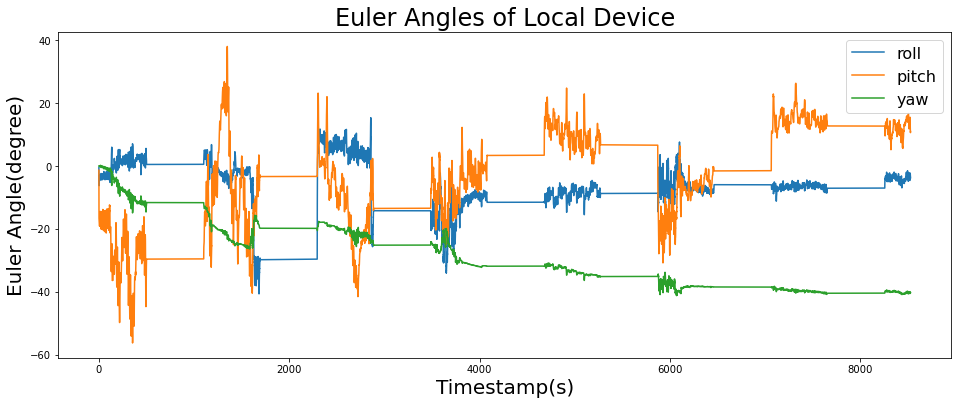

In [54]:
# Plot local data out
data_plot_G = pd.DataFrame(dat_lo, columns=["Timestamp", "roll", "pitch", "yaw"])
data_plot_G.plot(x="Timestamp", y=["roll", "pitch", "yaw"], figsize=(16, 6))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.title("Euler Angles of Local Device", fontsize="24")
plt.legend(fontsize="16", loc ="upper right")
plt.show()

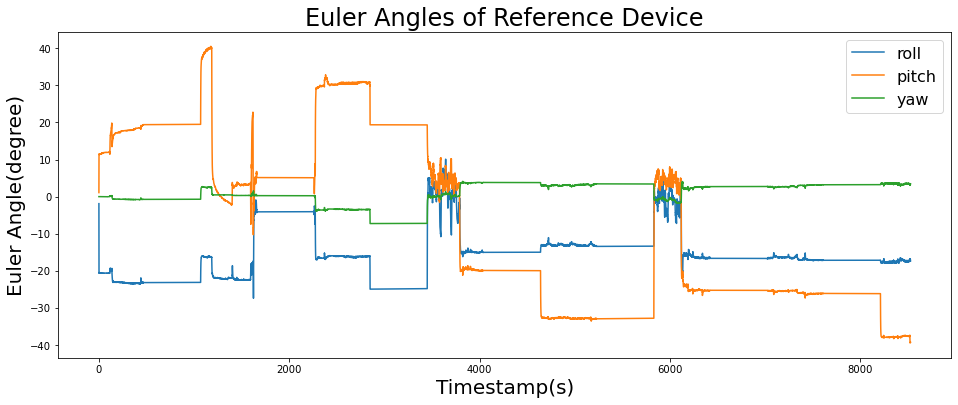

In [51]:
# Plot reference data out
data_plot_G = pd.DataFrame(dat_bg, columns=["Timestamp", "roll", "pitch", "yaw"])
data_plot_G.plot(x="Timestamp", y=["roll", "pitch", "yaw"], figsize=(16, 6))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.title("Euler Angles of Reference Device", fontsize="24")
plt.legend(fontsize="16", loc ="upper right")
plt.show()

In [305]:
# Check data and select time intervals
dat_lo1 = dat_lo.loc[(dat_lo['Timestamp'] >= 7055) & (dat_lo['Timestamp'] <= 7400)]

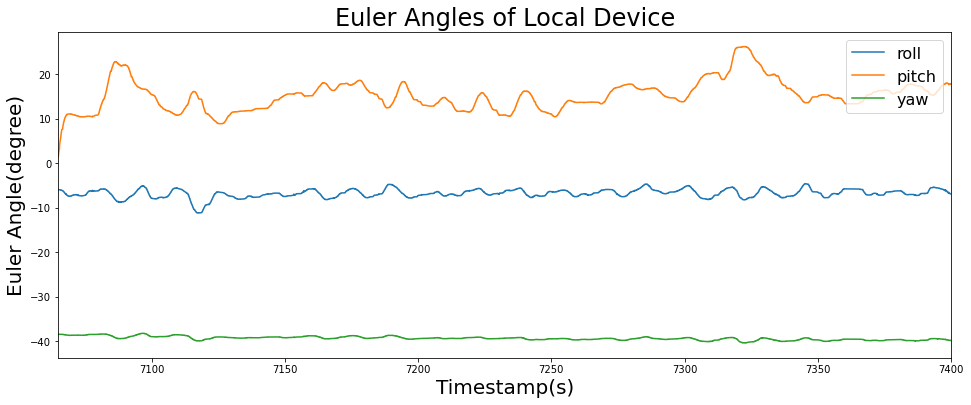

In [312]:
# Plot local data out
data_plot_G = pd.DataFrame(dat_lo1, columns=["Timestamp", "roll", "pitch", "yaw"])
data_plot_G.plot(x="Timestamp", y=["roll", "pitch", "yaw"], figsize=(16, 6))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.xlim(7065,7400)
#plt.ylim((-40, 40))
plt.title("Euler Angles of Local Device", fontsize="24")
plt.legend(fontsize="16", loc ="upper right")
plt.show()

In [53]:
def getSTD(timeseries):
    """
    Method to get mean pressure over considered timeframe.

    :param timeseries: (Array) Array containing pressure data from a given time interval (day/stresstest/etc.) for one specific pressure (ABP/ICP/etc.).
    :return: (float) Standard deviation of pressure data.
    """
    return timeseries.std()

In [313]:
# Select time intervals

dat_lo1 = dat_lo.loc[(dat_lo['Timestamp'] >= 2295) & (dat_lo['Timestamp'] <= 2900)]
dat_lo2 = dat_lo.loc[(dat_lo['Timestamp'] >= 4680) & (dat_lo['Timestamp'] <= 5275)]
dat_lo3 = dat_lo.loc[(dat_lo['Timestamp'] >= 7065) & (dat_lo['Timestamp'] <= 7400)]

dur1 = 2900 - 2295
dur2 = 5275 - 4680
dur3 = 7400 - 7065

In [298]:
w = 1600
peak_w = 200
timeseries = dat_lo1.roll.values
time = dat_lo1.Timestamp.values

time_w = time[int(w/2):len(time)-int(w/2)]
angle_w = timeseries[int(w/2):len(time)-int(w/2)]

#upper_thresh, lower_thresh, peaks_corrected, valleys_corrected, mov_avg
mov_avg = (np.convolve(timeseries, np.ones(w), 'same') / w)[int(w/2):len(timeseries)-int(w/2)]
timeseries_w = timeseries[int(w/2):len(timeseries)-int(w/2)]
upper_thresh = mov_avg + 0.25*getSTD(mov_avg)
lower_thresh = mov_avg - 0.25*getSTD(mov_avg)

peak_idx, _ = signal.find_peaks(timeseries_w, height=upper_thresh)
valley_idx, _ = signal.find_peaks(-timeseries_w, height=-lower_thresh)

peak_width = signal.peak_widths(timeseries_w, peak_idx)
valley_width = signal.peak_widths(-timeseries_w, valley_idx)
peaks_corrected = peak_idx[np.where(peak_width[0] > peak_w)]
valleys_corrected = valley_idx[np.where(valley_width[0] > peak_w)]
peaks = peaks_corrected
valleys = valleys_corrected

freq1 = (peaks.size/dur1)*60

In [299]:
freq1

3.867768595041322

In [301]:
peaks_outl_rm = []
valleys_outl_rm = []
for peak in peaks:
    if np.abs(angle_w[peak] - mov_avg[peak]) > 0.25*getSTD(mov_avg):
        peaks_outl_rm.append(peak)
for valley in valleys:
    if np.abs(angle_w[valley] - mov_avg[valley]) > 0.25*getSTD(mov_avg):
        valleys_outl_rm.append(valley)
        
peaks_outl_rm = np.array(peaks_outl_rm)
valleys_outl_rm = np.array(valleys_outl_rm)

In [302]:
piecewise_linear_peaks_outl_rm = np.interp(time_w, time_w[peaks_outl_rm], angle_w[peaks_outl_rm])
piecewise_linear_valleys_outl_rm = np.interp(time_w, time_w[valleys_outl_rm], angle_w[valleys_outl_rm])

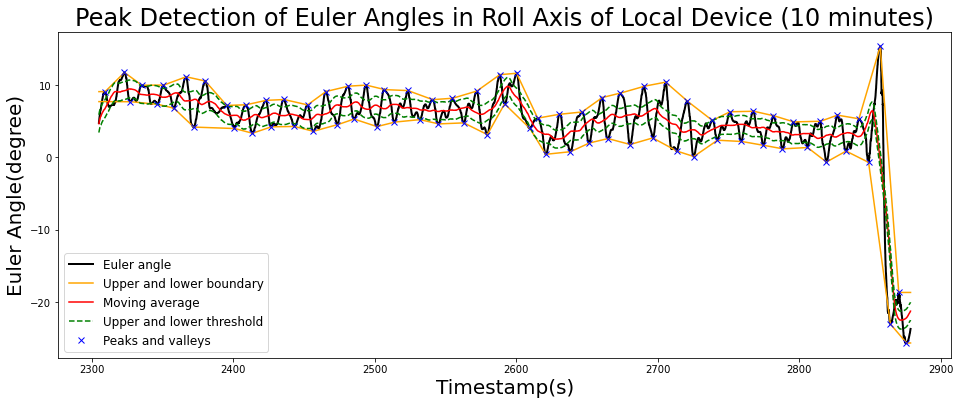

In [303]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
#ax.set_ylabel('Angle(degree)')
#ax.set_xlabel('Time(second)')
a1 = ax.plot(time_w, angle_w, color='black',linewidth=2.0, label = 'Euler angle')
a2 = ax.plot(time_w, piecewise_linear_peaks_outl_rm, color='orange', label = 'Upper and lower boundary')
a3 = ax.plot(time_w, piecewise_linear_valleys_outl_rm, color='orange')
a4 = ax.plot(time_w, mov_avg, color='red', label = 'Moving average')
a5 = ax.plot(time_w, upper_thresh, color='green', linestyle='dashed', label = 'Upper and lower threshold')
a6 = ax.plot(time_w, lower_thresh, color='green', linestyle='dashed')
a7 = ax.plot(time_w[peaks], angle_w[peaks], 'x', color='blue', label = 'Peaks and valleys')
a8 = ax.plot(time_w[valleys], angle_w[valleys], 'x', color='blue')
#ax.legend(loc='upper left')
#plt.xlim(7060,7660)
#plt.ylim((-12, -2))
ax.legend(fontsize="12")
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.title("Peak Detection of Euler Angles in Roll Axis of Local Device (10 minutes)", fontsize="24")
#plt.savefig('peak_detect_pitch.png')
plt.show()

In [292]:
w = 1600
peak_w = 200
timeseries = dat_lo2.roll.values
time = dat_lo2.Timestamp.values

time_w = time[int(w/2):len(time)-int(w/2)]
angle_w = timeseries[int(w/2):len(time)-int(w/2)]

#upper_thresh, lower_thresh, peaks_corrected, valleys_corrected, mov_avg
mov_avg = (np.convolve(timeseries, np.ones(w), 'same') / w)[int(w/2):len(timeseries)-int(w/2)]
timeseries_w = timeseries[int(w/2):len(timeseries)-int(w/2)]
upper_thresh = mov_avg + 0.25*getSTD(mov_avg)
lower_thresh = mov_avg - 0.25*getSTD(mov_avg)

peak_idx, _ = signal.find_peaks(timeseries_w, height=upper_thresh)
valley_idx, _ = signal.find_peaks(-timeseries_w, height=-lower_thresh)

peak_width = signal.peak_widths(timeseries_w, peak_idx)
valley_width = signal.peak_widths(-timeseries_w, valley_idx)
peaks_corrected = peak_idx[np.where(peak_width[0] > peak_w)]
valleys_corrected = valley_idx[np.where(valley_width[0] > peak_w)]
peaks = peaks_corrected
valleys = valleys_corrected

freq2 = (peaks.size/dur2)*60

In [ ]:
freq2

In [293]:
peaks_outl_rm = []
valleys_outl_rm = []
for peak in peaks:
    if np.abs(angle_w[peak] - mov_avg[peak]) > 0.25*getSTD(mov_avg):
        peaks_outl_rm.append(peak)
for valley in valleys:
    if np.abs(angle_w[valley] - mov_avg[valley]) > 0.25*getSTD(mov_avg):
        valleys_outl_rm.append(valley)
        
peaks_outl_rm = np.array(peaks_outl_rm)
valleys_outl_rm = np.array(valleys_outl_rm)

In [296]:
piecewise_linear_peaks_outl_rm = np.interp(time_w, time_w[peaks_outl_rm], angle_w[peaks_outl_rm])
piecewise_linear_valleys_outl_rm = np.interp(time_w, time_w[valleys_outl_rm], angle_w[valleys_outl_rm])

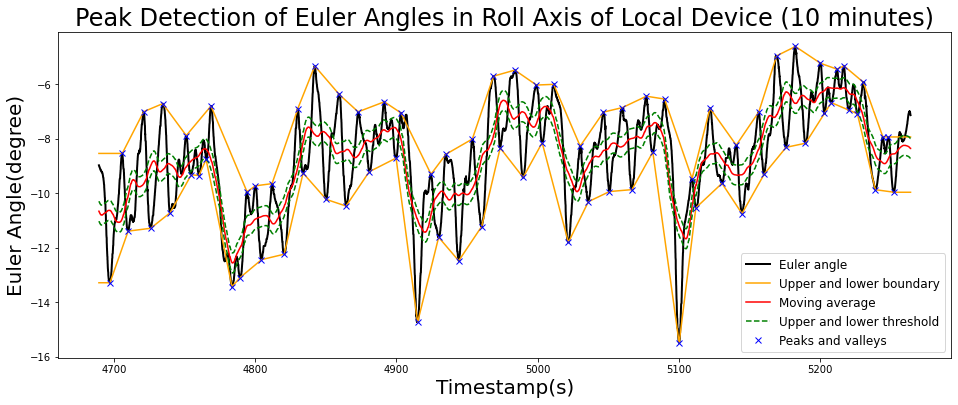

In [297]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
#ax.set_ylabel('Angle(degree)')
#ax.set_xlabel('Time(second)')
a1 = ax.plot(time_w, angle_w, color='black',linewidth=2.0, label = 'Euler angle')
a2 = ax.plot(time_w, piecewise_linear_peaks_outl_rm, color='orange', label = 'Upper and lower boundary')
a3 = ax.plot(time_w, piecewise_linear_valleys_outl_rm, color='orange')
a4 = ax.plot(time_w, mov_avg, color='red', label = 'Moving average')
a5 = ax.plot(time_w, upper_thresh, color='green', linestyle='dashed', label = 'Upper and lower threshold')
a6 = ax.plot(time_w, lower_thresh, color='green', linestyle='dashed')
a7 = ax.plot(time_w[peaks], angle_w[peaks], 'x', color='blue', label = 'Peaks and valleys')
a8 = ax.plot(time_w[valleys], angle_w[valleys], 'x', color='blue')
#ax.legend(loc='upper left')
#plt.xlim(7060,7660)
#plt.ylim((-12, -2))
ax.legend(fontsize="12")
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.title("Peak Detection of Euler Angles in Roll Axis of Local Device (10 minutes)", fontsize="24")
#plt.savefig('peak_detect_pitch.png')
plt.show()

In [333]:
w = 1600
peak_w = 200
timeseries = dat_lo3.roll.values
time = dat_lo3.Timestamp.values

time_w = time[int(w/2):len(time)-int(w/2)]
angle_w = timeseries[int(w/2):len(time)-int(w/2)]

#upper_thresh, lower_thresh, peaks_corrected, valleys_corrected, mov_avg
mov_avg = (np.convolve(timeseries, np.ones(w), 'same') / w)[int(w/2):len(timeseries)-int(w/2)]
timeseries_w = timeseries[int(w/2):len(timeseries)-int(w/2)]
upper_thresh = mov_avg + 0.25*getSTD(mov_avg)
lower_thresh = mov_avg - 0.25*getSTD(mov_avg)

peak_idx, _ = signal.find_peaks(timeseries_w, height=upper_thresh)
valley_idx, _ = signal.find_peaks(-timeseries_w, height=-lower_thresh)

peak_width = signal.peak_widths(timeseries_w, peak_idx)
valley_width = signal.peak_widths(-timeseries_w, valley_idx)
peaks_corrected = peak_idx[np.where(peak_width[0] > peak_w)]
valleys_corrected = valley_idx[np.where(valley_width[0] > peak_w)]
peaks = peaks_corrected
valleys = valleys_corrected

freq3 = (peaks.size/dur3)*60

In [334]:
freq3

3.582089552238806

In [335]:
peaks_outl_rm = []
valleys_outl_rm = []
for peak in peaks:
    if np.abs(angle_w[peak] - mov_avg[peak]) > 0.25*getSTD(mov_avg):
        peaks_outl_rm.append(peak)
for valley in valleys:
    if np.abs(angle_w[valley] - mov_avg[valley]) > 0.25*getSTD(mov_avg):
        valleys_outl_rm.append(valley)
        
peaks_outl_rm = np.array(peaks_outl_rm)
valleys_outl_rm = np.array(valleys_outl_rm)

In [337]:
piecewise_linear_peaks_outl_rm = np.interp(time_w, time_w[peaks_outl_rm], angle_w[peaks_outl_rm])
piecewise_linear_valleys_outl_rm = np.interp(time_w, time_w[valleys_outl_rm], angle_w[valleys_outl_rm])

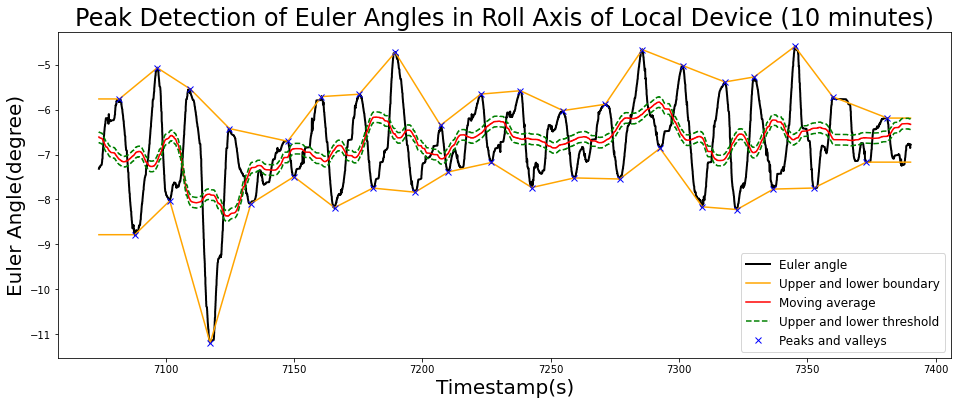

In [338]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
#ax.set_ylabel('Angle(degree)')
#ax.set_xlabel('Time(second)')
a1 = ax.plot(time_w, angle_w, color='black',linewidth=2.0, label = 'Euler angle')
a2 = ax.plot(time_w, piecewise_linear_peaks_outl_rm, color='orange', label = 'Upper and lower boundary')
a3 = ax.plot(time_w, piecewise_linear_valleys_outl_rm, color='orange')
a4 = ax.plot(time_w, mov_avg, color='red', label = 'Moving average')
a5 = ax.plot(time_w, upper_thresh, color='green', linestyle='dashed', label = 'Upper and lower threshold')
a6 = ax.plot(time_w, lower_thresh, color='green', linestyle='dashed')
a7 = ax.plot(time_w[peaks], angle_w[peaks], 'x', color='blue', label = 'Peaks and valleys')
a8 = ax.plot(time_w[valleys], angle_w[valleys], 'x', color='blue')
#ax.legend(loc='upper left')
#plt.xlim(7060,7660)
#plt.ylim((-12, -2))
ax.legend(fontsize="12")
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.title("Peak Detection of Euler Angles in Roll Axis of Local Device (10 minutes)", fontsize="24")
#plt.savefig('peak_detect_pitch.png')
plt.show()

In [343]:
# Scatter plot of peak frequency

part_x = np.array([1, 2, 3])
part_y = np.empty([3], dtype = float)
part_err = np.empty([3], dtype = float)
freq_roll = np.empty([3], dtype = float)
freq_roll[0] = freq1
freq_roll[1] = freq2
freq_roll[2] = freq3

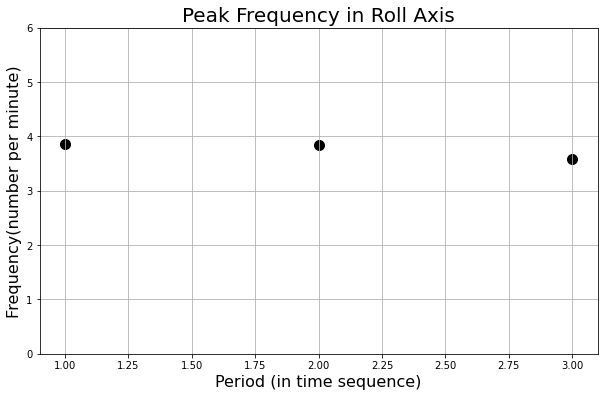

In [344]:
plt.scatter(part_x, freq_roll, alpha=1, color='black', s=100)
plt.title('Peak Frequency in Roll Axis', fontsize = 20)
plt.xlabel("Period (in time sequence)", fontsize = 16)
plt.ylabel("Frequency(number per minute)", fontsize = 16)
plt.grid()
plt.rcParams["figure.figsize"] = (10,6)
plt.ylim((0, 6))
plt.show()

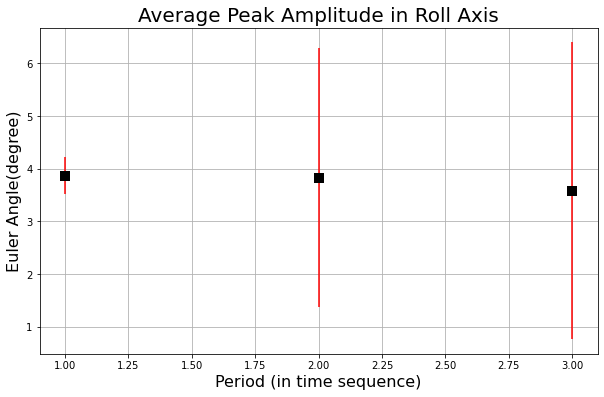

In [346]:
plt.errorbar(part_x, freq_roll, part_err, linestyle='None', marker='s', linewidth=1.5, color='red', mec='black', mfc='black', ms=6, mew=4)
plt.title('Average Peak Amplitude in Roll Axis', fontsize = 20)
plt.xlabel("Period (in time sequence)", fontsize = 16)
plt.ylabel("Euler Angle(degree)", fontsize = 16)
plt.grid()
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

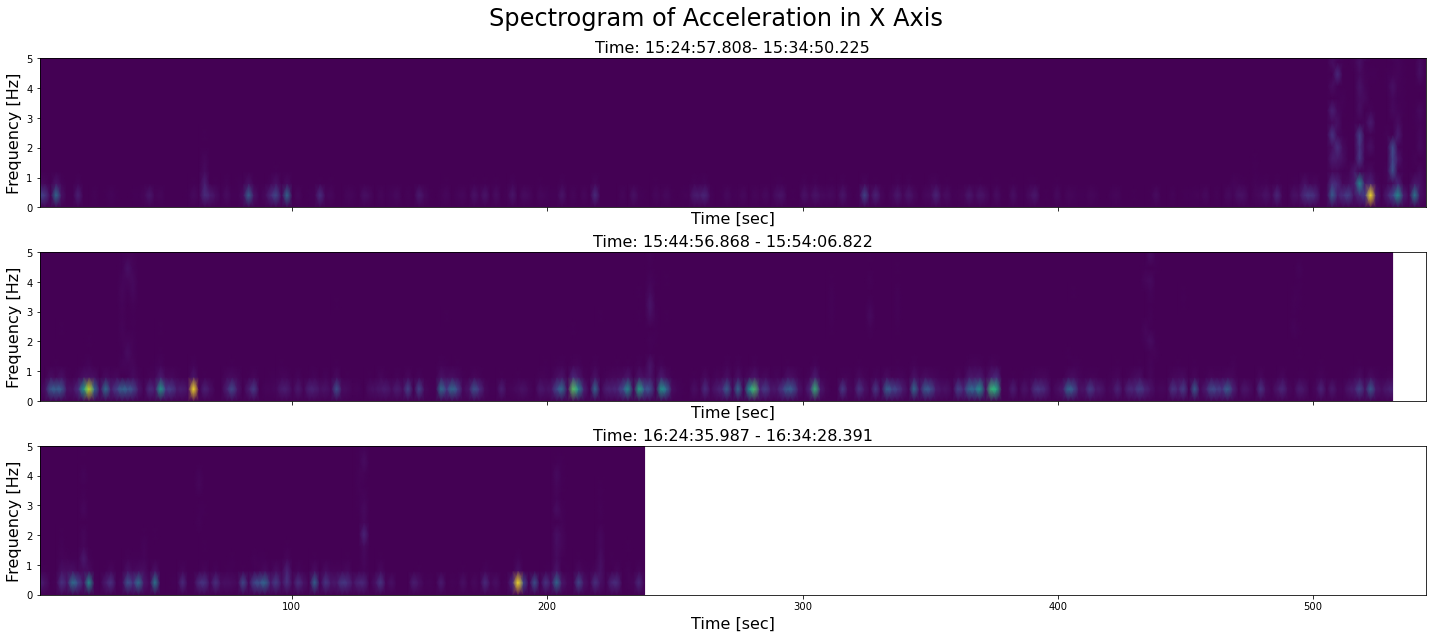

In [353]:
# Plot of Spectrogram

fs = 104
fig, ax = plt.subplots(nrows=3, sharex=True)
x1 = dat_lo1.XL_X
x2 = dat_lo2.XL_X
x3 = dat_lo3.XL_X

f1, t1, Sxx1 = signal.spectrogram(x1, fs)
f2, t2, Sxx2 = signal.spectrogram(x2, fs)
f3, t3, Sxx3 = signal.spectrogram(x3, fs)


ax[0].pcolormesh(t1, f1, Sxx1, shading='gouraud')
ax[0].set_title('Time: 15:24:57.808- 15:34:50.225', fontsize=16)
ax[0].set_ylabel('Frequency [Hz]', fontsize=16)
ax[0].set_xlabel('Time [sec]', fontsize=16)
ax[0].set_ylim(0,5)

ax[1].pcolormesh(t2, f2, Sxx2, shading='gouraud')
ax[1].set_title('Time: 15:44:56.868 - 15:54:06.822', fontsize=16)
ax[1].set_ylabel('Frequency [Hz]', fontsize=16)
ax[1].set_xlabel('Time [sec]', fontsize=16)
ax[1].set_ylim(0,5)

ax[2].pcolormesh(t3, f3, Sxx3, shading='gouraud')
ax[2].set_title('Time: 16:24:35.987 - 16:34:28.391', fontsize=16)
ax[2].set_ylabel('Frequency [Hz]', fontsize=16)
ax[2].set_xlabel('Time [sec]', fontsize=16)
ax[2].set_ylim(0,5)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('Spectrogram of Acceleration in X Axis', fontsize=24)
plt.rcParams["figure.figsize"] = (20,9)
plt.show()

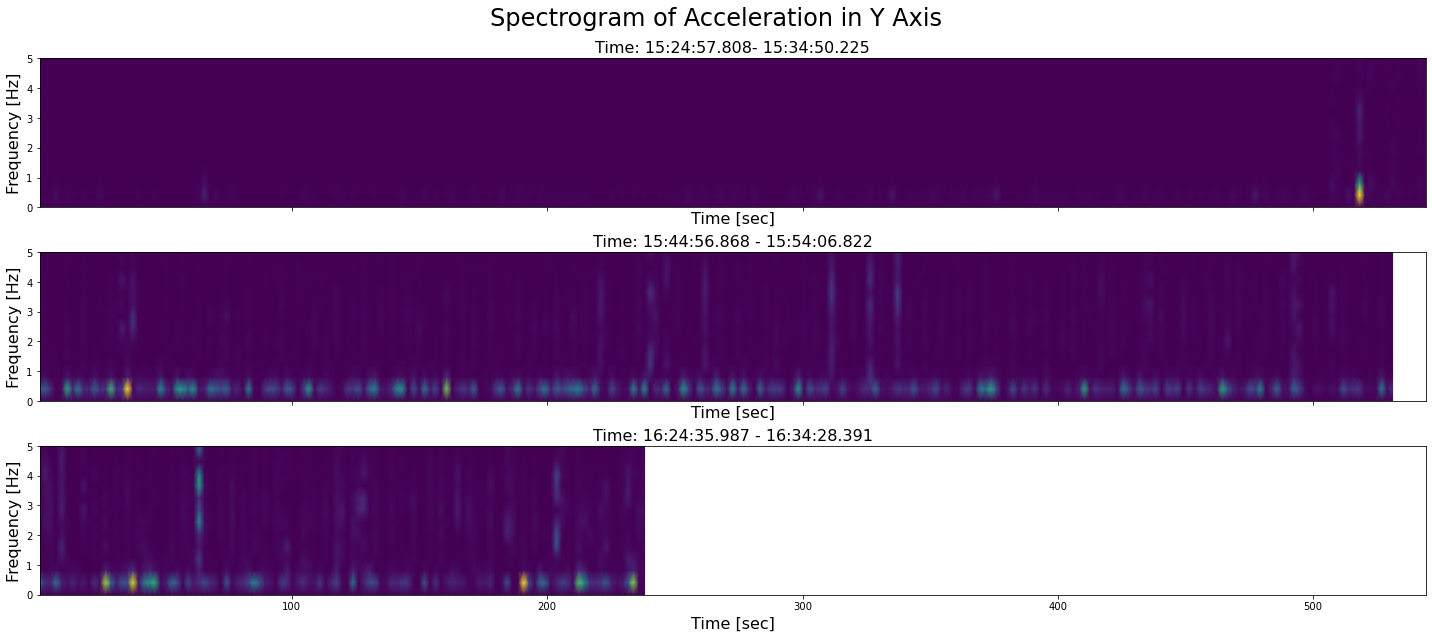

In [354]:
fs = 104
fig, ax = plt.subplots(nrows=3, sharex=True)
x1 = dat_lo1.XL_Y
x2 = dat_lo2.XL_Y
x3 = dat_lo3.XL_Y

f1, t1, Sxx1 = signal.spectrogram(x1, fs)
f2, t2, Sxx2 = signal.spectrogram(x2, fs)
f3, t3, Sxx3 = signal.spectrogram(x3, fs)


ax[0].pcolormesh(t1, f1, Sxx1, shading='gouraud')
ax[0].set_title('Time: 15:24:57.808- 15:34:50.225', fontsize=16)
ax[0].set_ylabel('Frequency [Hz]', fontsize=16)
ax[0].set_xlabel('Time [sec]', fontsize=16)
ax[0].set_ylim(0,5)

ax[1].pcolormesh(t2, f2, Sxx2, shading='gouraud')
ax[1].set_title('Time: 15:44:56.868 - 15:54:06.822', fontsize=16)
ax[1].set_ylabel('Frequency [Hz]', fontsize=16)
ax[1].set_xlabel('Time [sec]', fontsize=16)
ax[1].set_ylim(0,5)

ax[2].pcolormesh(t3, f3, Sxx3, shading='gouraud')
ax[2].set_title('Time: 16:24:35.987 - 16:34:28.391', fontsize=16)
ax[2].set_ylabel('Frequency [Hz]', fontsize=16)
ax[2].set_xlabel('Time [sec]', fontsize=16)
ax[2].set_ylim(0,5)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('Spectrogram of Acceleration in Y Axis', fontsize=24)
plt.rcParams["figure.figsize"] = (20,9)
plt.show()

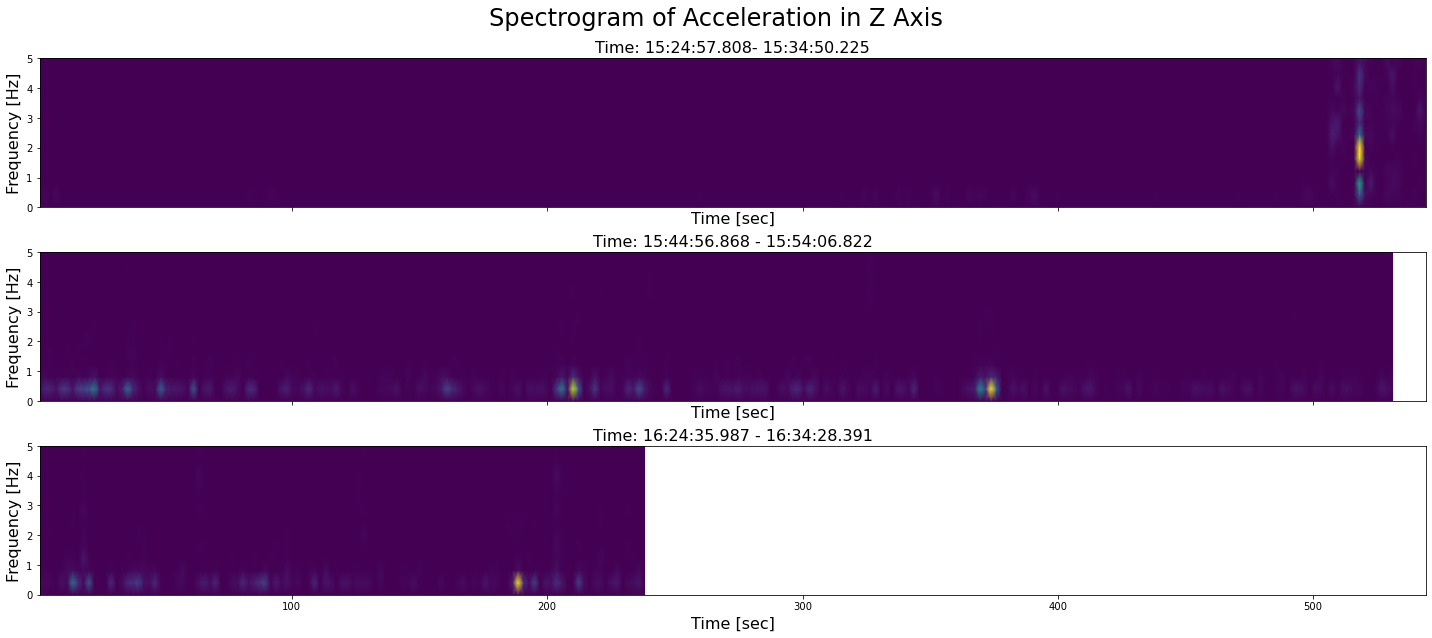

In [355]:
fs = 104
fig, ax = plt.subplots(nrows=3, sharex=True)
x1 = dat_lo1.XL_Z
x2 = dat_lo2.XL_Z
x3 = dat_lo3.XL_Z

f1, t1, Sxx1 = signal.spectrogram(x1, fs)
f2, t2, Sxx2 = signal.spectrogram(x2, fs)
f3, t3, Sxx3 = signal.spectrogram(x3, fs)


ax[0].pcolormesh(t1, f1, Sxx1, shading='gouraud')
ax[0].set_title('Time: 15:24:57.808- 15:34:50.225', fontsize=16)
ax[0].set_ylabel('Frequency [Hz]', fontsize=16)
ax[0].set_xlabel('Time [sec]', fontsize=16)
ax[0].set_ylim(0,5)

ax[1].pcolormesh(t2, f2, Sxx2, shading='gouraud')
ax[1].set_title('Time: 15:44:56.868 - 15:54:06.822', fontsize=16)
ax[1].set_ylabel('Frequency [Hz]', fontsize=16)
ax[1].set_xlabel('Time [sec]', fontsize=16)
ax[1].set_ylim(0,5)

ax[2].pcolormesh(t3, f3, Sxx3, shading='gouraud')
ax[2].set_title('Time: 16:24:35.987 - 16:34:28.391', fontsize=16)
ax[2].set_ylabel('Frequency [Hz]', fontsize=16)
ax[2].set_xlabel('Time [sec]', fontsize=16)
ax[2].set_ylim(0,5)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('Spectrogram of Acceleration in Z Axis', fontsize=24)
plt.rcParams["figure.figsize"] = (20,9)
plt.show()